# Building Machines that Learn to Learn: Self improving Rag for Biomedical Research

How I'm approaching the hallucination problem in LLm knowledge mining without expensive retraining.

---


## The problem

Imagine an LLm powered assistant confidently telling a researcher or a patient that a drug treats hypertension when in fact it's a known fact that this drug might increase blood pressure. In other domains this might be embarrassing in this field it's dangerous. At the time of writing, there are over 6 million articles archived in PubMed Central with biocurators archiving and annotating findings from these articles. With LLms this task has become easier but still needs manual verification due to the high stakes nature of this problem.

In the article below I'm going to show a brief extract from my work in OntoSemantics of how we can use ground truth knowledge from ontologies to inform the LLm about the context of the paper and let known truth guide the processing of extracting new novel relationships.

## Approach

The approach outlined in this post will follow this structure similar to traditional RAG systems:

```
Query  -----------------------Augment context-------------> Generate Answer
 |                                  ^
 |                                  |
 -> Static Knowledge Base -> Retrieve Information
```

However, the work we're proposing will flip this around a bit

```

Query ----------------------Augment context-------------> Generate Answer
 |                                  ^                            |
 |                                  |                            |
 ->  Knowledge Base -> Retrieve Information                      |
           ^                                                     |
           |                                                     |
           |                                                     |
           <-----Apply reasoning techniques---<-Integrate---------
```

which in theory will create a feedback loop where generated answers will be enriched by known ground truth and improve the knowledge base we'll discuss in a later blog post.

## Processing

Let us start by loading in our dataset. I will be using some samples from the [BIORed challenge](https://academic.oup.com/bib/article/doi/10.1093/bib/bbac282/6645993) which consists of around ~400 curated abstracts from Pubmed central ideal for training in bioc format.

We can use the help of a package called bioc to read the xml file and process each abstract's relationships and entities using the ```process_document``` function below


In [1]:
import pandas as pd
from bioc import biocxml

from knowledge_engine.models.ontology_match import OntologyMatch
from notebooks.processing_utils import parse_document
from typing import Dict

In [2]:
with open('../data/BioRED/Train.BioC.XML', 'r') as bio_red_file:
    collection = biocxml.load(bio_red_file)

In [3]:
processed_dataset = pd.DataFrame([parse_document(doc) for doc in collection.documents])

In [4]:
processed_dataset.head()

,relations,text,annotations
0,[StoredRelationship(subject=StoredEntity(text=...,Hepatocyte nuclear factor-6: associations betw...,{'3175': [StoredEntity(text='Hepatocyte nuclea...
1,[StoredRelationship(subject=StoredEntity(text=...,"Langerin, a novel C-type lectin specific to La...","{'50489': [StoredEntity(text='Langerin', canon..."
2,[StoredRelationship(subject=StoredEntity(text=...,Founder mutations in the BRCA1 gene in Polish ...,"{'672': [StoredEntity(text='BRCA1', canonical_..."
3,[StoredRelationship(subject=StoredEntity(text=...,Apomorphine: an underutilized therapy for Park...,"{'D001058': [StoredEntity(text='Apomorphine', ..."
4,[StoredRelationship(subject=StoredEntity(text=...,"Rab6c, a new member of the rab gene family, is...","{'84084': [StoredEntity(text='Rab6c', canonica..."


The function gives us a dataset of three columns:
 1. **Relations:** The relationships as a list of StoredRelationship objects
 2. **Text:** the text of the abstract
 3. **Annotations:** the annotations which are named entities found in the text. These are stored as a dictionary annotated by an id and a list of StoredEntity objects as an annotation is usually found in multiple places across the abstract. This would come in handy if we were to train a Named Entity Recognition or a Relationship Extraction model from scratch but since we're going to use an llm for processing this time round we can gloss over this bit.

## Methodology

Now that we have the processed the dataset at hand and can work with it, we can run some experiments. We want to measure the impact of context and context types on the prompt passed to the llm to enable it to effectively extract the relationships out of the abstract. The way we want to evaluate this is by first using the plain prompt and measure its performance, then we are going to run an experiment by just passing the annotations that the llm should focus on when forming the relationships, and finally we're going to be passing the enriched relationships from the relevant ontologies.

### Prompt and Model

Since we're going to be working with an LLM we'll be using the following prompt which we're going to use a template and built into the ```LLmExtractor``` Class which follows basic prompt engineering techniques... ie describe the role, add the required text, instruct the LLM it's role, only allow it to return valid JSON. The aim of this blog is to force the llm to extract meaningful relationships without explicit tuning.
```
You are a biomedical expert analyzing scientific literature. Extract relationships between biomedical entities from the given text.

Text: {text}

Instructions:
1. Identify biomedical entities (diseases, drugs, genes, symptoms, etc.)
2. Find explicit relationships between these entities
3. Return relationships in JSON format with high confidence only

Return ONLY a JSON array with this exact format:
[
  {{
    "subject": "entity1",
    "predicate": "relationship_type",
    "object": "entity2",
    "evidence": "exact text supporting this relationship",
    "confidence": 0.85
  }}
]

Valid relationship types: causes, treats, increases_risk_for, decreases_risk_for, biomarker_for, positive_correlation, negative_correlation, association, bind, prevents

Focus on explicit, clear relationships. Avoid speculation.

JSON:
```

The model we'll be using is [gemma3:1b](https://ollama.com/library/gemma3) which is a small quantised model built and maintained by google designed to run on mobile devices. While it scores well in a variety of benchmarks it's not the latest and greatest model ever, however it should be more than enough for this use case. __Note__ this class assumes that you have an OLlama instance running with gemma3.

In [5]:
from nlp_processor.llm_extractor import LLMRelationshipExtractor

relationship_extractor = LLMRelationshipExtractor('gemma3:1b')
relationship_extractor

/Users/drago/PycharmProjects/bioengine/bioengine/nlp_processor/llm_extractor.py:102: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  return Ollama(model=self.model_name, temperature=0.1, base_url="http://localhost:11434")


### Metrics

First things first we need to discuss the evaluation metrics we're going to use to compare the experiments. In this case we can treat the problem like a classification problem where the model decides if the relationship exists or not. This means we can use the standard classification metrics we've come to know but I'll include them as a refresher below.

#### Confusion Matrix
Let's establish our ground truth first... for each potential relationship in our evaluation set, the model's prediction can land in four possible outcomes:

**True Positives (TP)**: Relationships that actually exist in the text and our model correctly identified
**False Positives (FP)**: Relationships that don't exist in the text but our model incorrectly claimed they do
**False Negatives (FN)**: Relationships that exist in the text but our model failed to identify
**True Negatives (TN)**: Relationships that don't exist in the text and our model correctly identified as non-existent

#### Core metrics

Given these outcomes we can define:
- **Precision**: measures how many of the relationships our model extracted are actually correct: $ \text{Precision} = \frac{TP}{TP + FP} $
- **Recall**: (also known as sensitivity) measures how many of the actual relationships in the text our model successfully captured: $ \text{Recall} = \frac{TP}{TP + FN} $
- **F1 Score**: provides a balanced measure that considers both precision and recall:
$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $

Since we're comparing the plain prompt against the annotation-focused approach and finally the ontology-enriched version, these metrics will reveal different aspects of improvement:

- Precision improvements will show us whether adding context helps the model make more accurate relationship predictions
- Recall improvements will indicate whether richer context helps the model discover relationships it would otherwise miss
- F1-score changes will give us the overall picture of whether our context enrichment strategies genuinely improve relationship extraction performance

For the sake of convenience and brevity,  I included the Relationship evaluator class below which will allow us to compute these metrics easily.


In [6]:
from utils.eval import RelationshipEvaluator

evaluator = RelationshipEvaluator(matching_strategy="fuzzy")

In [7]:
extracted_relationships_no_context = relationship_extractor.extract_relationships(processed_dataset.loc[0, 'text'], )

2025-06-11 10:20:30,913 - urllib3.connectionpool - DEBUG - Starting new HTTP connection (1): localhost:11434
2025-06-11 10:20:32,331 - urllib3.connectionpool - DEBUG - http://localhost:11434 "POST /api/generate HTTP/1.1" 200 None
2025-06-11 10:20:43,103 - urllib3.connectionpool - DEBUG - Starting new HTTP connection (1): localhost:11434
2025-06-11 10:20:43,638 - urllib3.connectionpool - DEBUG - http://localhost:11434 "POST /api/generate HTTP/1.1" 200 None


In [8]:
def format_relationships(relations):
    return '\n'.join({' -> '.join([relation.subject, relation.predicate, relation.object]) for relation in relations})
print(format_relationships(extracted_relationships_no_context))

Type II diabetes mellitus -> genetic_variability -> HNF-6 gene
Type II diabetes mellitus -> genetic_variability -> MODY1, MODY3, MODY4 genes
Type II diabetes mellitus -> treats -> Maturity-onset diabetes of the young
Type II diabetes mellitus -> estimates_of_insulin_secretion -> Insulin secretion
Type II diabetes mellitus -> glucose_induced_serum_insulin -> Serum insulin
Type II diabetes mellitus -> decreases_risk_for -> Glucose tolerant subjects
Type II diabetes mellitus -> increases_risk_for -> Genetic variability
Type II diabetes mellitus -> glucose_induced_serum_c_peptide -> C-peptide


Without any context we can see that the model produced a number of hallucinated responses back, these two relationships are particularly funny:
```
Type II diabetes mellitus -> increases_risk_for -> Glucose tolerant subjects
Type II diabetes mellitus -> decreases_risk_for -> Glucose tolerant subjects
```

Beyond the obvious contradiction i.e. ... the same condition cannot both increase AND decrease risk for the same outcome apart from the fact the subject and the object of the relationships are wrong (Glucose tolerant subject would have a decreased risk of Diabetes), we can see that the predicates themselves don't follow our instructed format.

One might argue that we could post-process these contradictions after the initial query, but:
 - it requires additional computational overhead
 - and most importantly: *doesn't* address the root cause of hallucination,
 - it may miss more subtle inconsistencies that aren't as obviously contradictory.


In [9]:
evaluation_no_context = evaluator.evaluate(extracted_relationships_no_context, processed_dataset.loc[0, 'relations'])
evaluation_no_context.overall_metrics

PerformanceMetrics(precision=0.0, recall=0.0, f1_score=0.0, true_positives=0, false_positives=9, false_negatives=3, support=3)

The performance metrics in this document speak for themselves with an fscore of 0 and 8 false positives and 3 false negatives.

#### Entity injection

Let's run another experiment where we add the annotations to the context. Note this isn't cheating as we're evaluating the model purely on relationship extraction so helping the model with the entities it should focus on should shope it further on the task at hand.

In [10]:
[annotation[0].canonical_name for annotation in processed_dataset.loc[0, 'annotations'].values()]

['Hepatocyte nuclear factor-6',
 'type II diabetes',
 'insulin',
 'glucose',
 'MODY',
 'MODY1',
 'MODY3',
 'MODY4',
 'patients',
 'Pro75 Ala']

In [11]:
extracted_relationships_entities = relationship_extractor.extract_relationships(processed_dataset.loc[0, 'text'], context={'entities': [annotation[0].canonical_name for annotation in processed_dataset.loc[0, 'annotations'].values()]})

2025-06-11 10:20:53,779 - urllib3.connectionpool - DEBUG - Starting new HTTP connection (1): localhost:11434
2025-06-11 10:20:54,099 - urllib3.connectionpool - DEBUG - http://localhost:11434 "POST /api/generate HTTP/1.1" 200 None
2025-06-11 10:21:07,659 - urllib3.connectionpool - DEBUG - Starting new HTTP connection (1): localhost:11434
2025-06-11 10:21:08,261 - urllib3.connectionpool - DEBUG - http://localhost:11434 "POST /api/generate HTTP/1.1" 200 None


In [12]:
print(format_relationships(extracted_relationships_entities))

Hepatocyte nuclear factor-6 -> association -> genetic variability
MODY4 -> association -> Type II diabetes
Type II diabetes -> increases_risk_for -> genetic variability
Type II diabetes -> treats -> insulin secretion
Hepatocyte nuclear factor-6 -> association -> Type II diabetes
MODY3 -> association -> Type II diabetes
patients -> experiences -> late-onset Type II diabetes
MODY1 -> association -> Type II diabetes


In [13]:
evaluation_entities = evaluator.evaluate(extracted_relationships_entities, processed_dataset.loc[0, 'relations'])
evaluation_entities.overall_metrics

PerformanceMetrics(precision=0.08333333333333333, recall=0.3333333333333333, f1_score=0.13333333333333333, true_positives=1, false_positives=11, false_negatives=2, support=3)

Whilst we're improving on the baseline we can still do significantly better than this. An f1_score of 0.15 is frankly abysmal for any practical application. And we're also greeted by another amusing hallucination::
 ```Type II diabetes -> treats -> insulin secretion```

This relationship demonstrates a fundamental misunderstanding of causality - diseases don't "treat" biological processes. This suggests that even with basic context, the model still struggles with domain-specific reasoning and appropriate predicate selection.

#### Ontological Context

In the following experiment we're going to include the canonical knowledge to help guide the llm infer and new relationships from the abstract we passed to it. To do this we're going to load some popular ontologies relevant to this case (MONDO(disease ontology), GO(gene ontology), and HP(the phenotype ontology)) through this OntologyManager class

In [14]:
from pathlib import Path
from importlib import reload
import knowledge_engine.ontology_manager as ontology_manager
reload(ontology_manager)


<module 'knowledge_engine.ontology_manager' from '/Users/drago/PycharmProjects/bioengine/bioengine/knowledge_engine/ontology_manager.py'>

In [ ]:
extracted_relationships_entities = relationship_extractor.extract_relationships(processed_dataset.loc[0, 'text'], context={'entities': [annotation[0].canonical_name for annotation in processed_dataset.loc[0, 'annotations'].values()]})

2025-06-11 10:21:21,360 - urllib3.connectionpool - DEBUG - Starting new HTTP connection (1): localhost:11434
2025-06-11 10:21:21,692 - urllib3.connectionpool - DEBUG - http://localhost:11434 "POST /api/generate HTTP/1.1" 200 None


In [16]:
om = ontology_manager.OntologyManager(ontology_dir=Path('../data/ontologies'))

Loading mondo...


/Users/drago/PycharmProjects/bioengine/bioengine/knowledge_engine/ontology_manager.py:75: UnicodeWarning: unsound encoding, assuming utf-8 (99% confidence)
  self.ontologies[onto_name] = pronto.Ontology(str(obo_file))


✅ mondo: 56695 terms
Loading hp...
2025-06-11 09:14:03,974 - chardet.charsetprober - DEBUG - EUC-TW Taiwan prober hit error at byte 989
2025-06-11 09:14:03,988 - chardet.charsetprober - DEBUG - utf-8  confidence = 0.505
2025-06-11 09:14:03,989 - chardet.charsetprober - DEBUG - SHIFT_JIS Japanese confidence = 0.01
2025-06-11 09:14:03,989 - chardet.charsetprober - DEBUG - EUC-JP Japanese confidence = 0.01
2025-06-11 09:14:03,989 - chardet.charsetprober - DEBUG - GB2312 Chinese confidence = 0.01
2025-06-11 09:14:03,989 - chardet.charsetprober - DEBUG - EUC-KR Korean confidence = 0.01
2025-06-11 09:14:03,990 - chardet.charsetprober - DEBUG - CP949 Korean confidence = 0.01
2025-06-11 09:14:03,990 - chardet.charsetprober - DEBUG - Big5 Chinese confidence = 0.01
2025-06-11 09:14:03,990 - chardet.charsetprober - DEBUG - EUC-TW not active
2025-06-11 09:14:03,990 - chardet.charsetprober - DEBUG - Johab Korean confidence = 0.01
2025-06-11 09:14:03,991 - chardet.charsetprober - DEBUG - windows-125

/Users/drago/PycharmProjects/bioengine/bioengine/knowledge_engine/ontology_manager.py:75: UnicodeWarning: unsound encoding, assuming ISO-8859-1 (73% confidence)
  self.ontologies[onto_name] = pronto.Ontology(str(obo_file))


✅ hp: 19653 terms
Loading go...
✅ go: 48106 terms
Loading cl...
❌ Failed to load cl: expected EOL, QuotedString, RFC3987_IriPctEncoded, or RFC3987_IriUCSChar (cl.obo, line 181636)
Loading uberon...


/opt/homebrew/Caskroom/mambaforge/base/envs/ontosemantics/lib/python3.12/site-packages/pronto/parsers/_fastobo.py:49: NotImplementedWarning: cannot process `treat-xrefs-as-equivalent: AEO` macro
  process_clause_header(clause, metadata, self.ont)
/opt/homebrew/Caskroom/mambaforge/base/envs/ontosemantics/lib/python3.12/site-packages/pronto/parsers/_fastobo.py:49: NotImplementedWarning: cannot process `treat-xrefs-as-equivalent: BILA` macro
  process_clause_header(clause, metadata, self.ont)
/opt/homebrew/Caskroom/mambaforge/base/envs/ontosemantics/lib/python3.12/site-packages/pronto/parsers/_fastobo.py:49: NotImplementedWarning: cannot process `treat-xrefs-as-equivalent: BSPO` macro
  process_clause_header(clause, metadata, self.ont)
/opt/homebrew/Caskroom/mambaforge/base/envs/ontosemantics/lib/python3.12/site-packages/pronto/parsers/_fastobo.py:49: NotImplementedWarning: cannot process `treat-xrefs-as-equivalent: CARO` macro
  process_clause_header(clause, metadata, self.ont)
/opt/home

❌ Failed to load uberon: expected EOL, QuotedString, RFC3987_IriPctEncoded, or RFC3987_IriUCSChar (uberon.obo, line 166503)


In [17]:
await om.download_and_load_ontologies()

  0%|          | 0/5 [00:00<?, ?it/s]/Users/drago/PycharmProjects/bioengine/bioengine/knowledge_engine/ontology_manager.py:62: UnicodeWarning: unsound encoding, assuming utf-8 (99% confidence)
  self.ontologies[onto_name] = pronto.Ontology(str(obo_file))
 20%|██        | 1/5 [00:03<00:13,  3.43s/it]

2025-06-11 09:14:11,097 - chardet.charsetprober - DEBUG - EUC-TW Taiwan prober hit error at byte 989
2025-06-11 09:14:11,111 - chardet.charsetprober - DEBUG - utf-8  confidence = 0.505
2025-06-11 09:14:11,111 - chardet.charsetprober - DEBUG - SHIFT_JIS Japanese confidence = 0.01
2025-06-11 09:14:11,111 - chardet.charsetprober - DEBUG - EUC-JP Japanese confidence = 0.01
2025-06-11 09:14:11,112 - chardet.charsetprober - DEBUG - GB2312 Chinese confidence = 0.01
2025-06-11 09:14:11,112 - chardet.charsetprober - DEBUG - EUC-KR Korean confidence = 0.01
2025-06-11 09:14:11,112 - chardet.charsetprober - DEBUG - CP949 Korean confidence = 0.01
2025-06-11 09:14:11,112 - chardet.charsetprober - DEBUG - Big5 Chinese confidence = 0.01
2025-06-11 09:14:11,112 - chardet.charsetprober - DEBUG - EUC-TW not active
2025-06-11 09:14:11,113 - chardet.charsetprober - DEBUG - Johab Korean confidence = 0.01
2025-06-11 09:14:11,113 - chardet.charsetprober - DEBUG - windows-1251 Russian confidence = 0.01
2025-06

/Users/drago/PycharmProjects/bioengine/bioengine/knowledge_engine/ontology_manager.py:62: UnicodeWarning: unsound encoding, assuming ISO-8859-1 (73% confidence)
  self.ontologies[onto_name] = pronto.Ontology(str(obo_file))
 80%|████████  | 4/5 [00:06<00:01,  1.25s/it]/opt/homebrew/Caskroom/mambaforge/base/envs/ontosemantics/lib/python3.12/site-packages/pronto/parsers/_fastobo.py:49: NotImplementedWarning: cannot process `treat-xrefs-as-equivalent: AEO` macro
  process_clause_header(clause, metadata, self.ont)
/opt/homebrew/Caskroom/mambaforge/base/envs/ontosemantics/lib/python3.12/site-packages/pronto/parsers/_fastobo.py:49: NotImplementedWarning: cannot process `treat-xrefs-as-equivalent: BILA` macro
  process_clause_header(clause, metadata, self.ont)
/opt/homebrew/Caskroom/mambaforge/base/envs/ontosemantics/lib/python3.12/site-packages/pronto/parsers/_fastobo.py:49: NotImplementedWarning: cannot process `treat-xrefs-as-equivalent: BSPO` macro
  process_clause_header(clause, metadata,

Loaded mondo,hp,go
❌Could not load: cl,uberon


In [18]:
insulin_matches = om.validate_and_enrich_entity('insulin')

In [19]:
def _format_isa_style(hierarchy_data) -> list[str]:
    """Format as ISA relationships. We can make these fancier through a first order logic reasoner but for now these are all isa relationships"""
    lines = []
    for parent in hierarchy_data.parents:
        lines.append(f"{hierarchy_data.canonical_name} ISA {parent.name}")
    for child in hierarchy_data.children:
        lines.append(f"{child.name} ISA {hierarchy_data.canonical_name}")
    return lines

print([_format_isa_style(insulin_match) for insulin_match in insulin_matches])

[['insulin ISA polypeptide', 'insulin ISA heterodetic cyclic peptide', 'insulin ISA peptide hormone', 'insulin (human) ISA insulin'], ['insulin secreting cell ISA protein secreting cell', 'insulin secreting cell ISA peptide hormone secreting cell', 'insulin secreting cell ISA eukaryotic cell', 'type B pancreatic cell ISA insulin secreting cell'], ['exposure to theraputic insulin treatment ISA exposure to glycemic agents'], ['Hyperinsulinemic hypoglycemia ISA Hyperinsulinemia'], ['Insulin-resistant diabetes mellitus ISA Diabetes mellitus', 'Insulin-resistant diabetes mellitus ISA Insulin resistance', 'Neonatal insulin-dependent diabetes mellitus ISA Insulin-resistant diabetes mellitus', 'Insulin-resistant diabetes mellitus at puberty ISA Insulin-resistant diabetes mellitus']]


In [21]:
matches = {annotation[0].canonical_name: om.validate_and_enrich_entity(annotation[0].canonical_name) for annotation in processed_dataset.loc[0, 'annotations'].values()}

In [66]:
extracted_relationships_semantic_context = relationship_extractor.extract_relationships(processed_dataset.loc[0, 'text'], context={'semantic relationships': {entity: '|'.join(_format_isa_style(term)) for entity, terms in matches.items() for term in terms}, 'extra instructions': 'Use these hierarchical relationships and entities to inform relationship extraction. Avoid creating relationships that contradict these ontological structures or repetition.'})

2025-06-11 09:37:49,680 - urllib3.connectionpool - DEBUG - Starting new HTTP connection (1): localhost:11434
2025-06-11 09:37:50,502 - urllib3.connectionpool - DEBUG - http://localhost:11434 "POST /api/generate HTTP/1.1" 200 None
2025-06-11 09:38:05,538 - urllib3.connectionpool - DEBUG - Starting new HTTP connection (1): localhost:11434
2025-06-11 09:38:06,249 - urllib3.connectionpool - DEBUG - http://localhost:11434 "POST /api/generate HTTP/1.1" 200 None


In [67]:
print(format_relationships(extracted_relationships_semantic_context))

Hepatocyte nuclear factor-6 -> association -> genetic variability
Hepatocyte nuclear factor-6 -> association -> Type II diabetes
Hepatocyte nuclear factor-6 -> association -> maturity-onset diabetes of the young
Hepatocyte nuclear factor-6 -> association -> late-onset Type II diabetes
Hepatocyte nuclear factor-6 -> association -> estimates of insulin secretion
Hepatocyte nuclear factor-6 -> is a biomarker for -> Type II diabetes


In [68]:
[(relation.subject.text,relation.predicate, relation.object.text) for relation in processed_dataset.loc[0, 'relations']]

[('Hepatocyte nuclear factor-6', 'Association', 'type II diabetes'),
 ('glucose', 'Positive_Correlation', 'insulin'),
 ('glucose', 'Association', 'type II diabetes')]

In [72]:
evaluation_semantic_context = evaluator.evaluate(extracted_relationships_semantic_context, processed_dataset.loc[0, 'relations']).overall_metrics
evaluation_semantic_context

PerformanceMetrics(precision=0.3333333333333333, recall=0.6666666666666666, f1_score=0.4444444444444444, true_positives=4, false_positives=8, false_negatives=2, support=3)

In [86]:
evaluation_no_context.overall_metrics

PerformanceMetrics(precision=0.0, recall=0.0, f1_score=0.0, true_positives=0, false_positives=12, false_negatives=3, support=3)

In [96]:
results_data = {
    'Context Type': ['Entity Context', 'Semantic Context'],
    'Precision': [
        evaluation_entities.overall_metrics.precision,
        evaluation_semantic_context.precision
    ],
    'Recall': [
        evaluation_entities.overall_metrics.recall,
        evaluation_semantic_context.recall
    ],
    'F1-Score': [
        evaluation_entities.overall_metrics.f1_score,
        evaluation_semantic_context.f1_score
    ]
}
all_results = pd.DataFrame(results_data)

2025-06-11 10:19:46,134 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-06-11 10:19:46,135 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/opt/homebrew/Caskroom/mambaforge/base/envs/ontosemantics/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-06-11 10:19:46,135 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/opt/homebrew/Caskroom/mambaforge/base/envs/ontosemantics/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-06-11 10:19:46,136 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/opt/homebrew/Caskroom/mambaforge/base/env

<Axes: xlabel='Metric', ylabel='Score'>

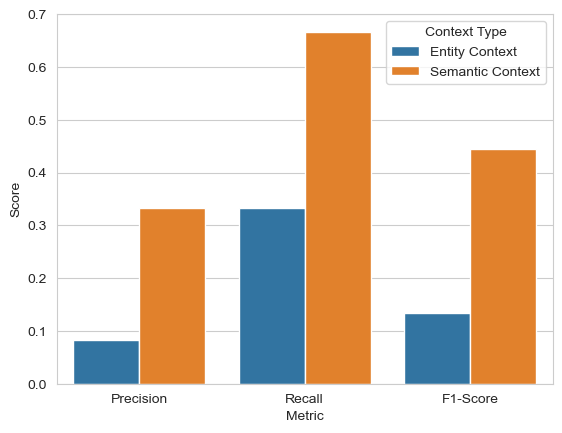

In [99]:
import seaborn as sns
sns.barplot(data=all_results.melt(
    id_vars=['Context Type'],
    value_vars=['Precision', 'Recall', 'F1-Score'],
    var_name='Metric',
    value_name='Score'
), hue='Context Type', x='Metric', y='Score')

Including the semantic context from ontologies yielded almost a 3 fold increase over the version where we only passed the named entities as context achieving an F1-score of 0.44 (precision = 0.33, recall = 0.67).

The extracted relationships show a marked improvement in both accuracy and semantic coherence:
```
Hepatocyte nuclear factor-6 -> association -> genetic variability
Hepatocyte nuclear factor-6 -> association -> Type II diabetes
Hepatocyte nuclear factor-6 -> association -> maturity-onset diabetes of the young
Hepatocyte nuclear factor-6 -> association -> late-onset Type II diabetes
Hepatocyte nuclear factor-6 -> association -> estimates of insulin secretion
Hepatocyte nuclear factor-6 -> is a biomarker for -> Type II diabetes
```
The model identifies correctly the central role of Hepatocyte nuclear factor-6 from the paper and appropriately uses domain-appropriate predicates like "association" and "is a biomarker for." However, the system still missed some key relationships present in the text, particularly `('glucose', 'Positive_Correlation', 'insulin')` and `('glucose', 'Association', 'type II diabetes')`. This phenomenon is captured by the relatively low precision (0.33) suggesting that some relationships are over inferred or extracted incorrectly.

# Future improvements

Currently, we're only providing the ontological context as raw text through an isa relationship but the llm is not able to process these relationships optimally as shown from the low precision however if we have:
1. **Embedding-Based Context Integration**: Pre-compute embeddings for ontological terms and their relationships, then use similarity search to dynamically select the most relevant ontological term and relationships for each abstract. We can also prioritise ontological terms and relationships based on what is more likely to improve the extracted information.
2. **Hierarchical Embedding Structures**: Use an embedding space that preserve parent-child relationships, ensuring that semantically related terms cluster appropriately in the vector space
3. **Multi Modal Model Fusion**: Build a model that fuses the structured graph relationships to the llm embedding
